In [1]:
import pandas as pd
import numpy as np

In [2]:
import sympy as sp

In [3]:
import seaborn as sns

/home/m/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from scipy import stats

In [5]:
from numba import jit

# Overview

Given a trading system model $F_{t}(\theta)$, the goal is to adjust the parameters $\theta$ in order to maximise $U_{t}$ (wealth).

# $$ \frac{dU_{T}(\theta)}{d\theta} = 
\sum \limits _{t=1} ^ {T} 
\frac{dU_{T}}{dR_{t}} 
\{ \frac{dR_{t}}{dF_{t}} \frac{dF_{t}}{d\theta} + \frac{dR_{t}}{dF_{t-1}} \frac{dF_{t-1}}{d\theta}  \}$$

Where:
* $U$ = wealth function (Sharpe ratio / Sterling ratio)
* $R_{t}$ = realised returns 
* $r_{t}$ = asset returns
* $F_{t}$ = position  
* $\theta$ = model weights
* $\delta$ = transaction costs
* $\mu$ = max position (multiplied by $F_{t}$ which goes from -1 to 1)

#### References

* J. Moody and M. Saffell, "Learning to trade via direct reinforcement," in IEEE Transactions on Neural Networks, vol. 12, no. 4, pp. 875-889, July 2001, doi: 10.1109/72.935097.

* https://teddykoker.com/2019/06/trading-with-reinforcement-learning-in-python-part-ii-application/
* http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf

#### Load derivative functions from standalone notebook

In [6]:
%run 3_reinforcement_trading_simple_derivs.ipynb

-----

In [7]:
N = 1/100
NUM_RETURNS = M = 8

## Calculate positions based on $tanh(\theta \cdot state)$

State takes the form: $[1, R_{t}, R_{t-1}, ..., R_{t-M}, F_{t-1}]$ 

In [8]:
def positions(r, theta):
    '''
    Apply weights to state to determine positisons
    '''
    
    T = len(r)
    Ft = np.zeros(T)
    for t in range(M, T):
        state = np.concatenate([ [1], r[t - M:t], [Ft[t-1]] ])
        Ft[t] = np.tanh(np.dot(theta, state))
        
    return Ft

In [9]:
def returns(Ft, r, delta):
    '''
    Calculate realised returns based on positions and fees
    '''
    T = len(r)
    R = (Ft[0:T-1] * r[1:T]) - delta * (np.abs(Ft[1:T] - Ft[0:T-1]))
    return np.concatenate((np.array([0]), R))

-----

In [10]:
def gradient(rets, theta, delta):
    Ft = positions(rets, theta) 
    R = returns(Ft, rets, delta) 
   
    # I don't think i need to calc this for all time here, 
    # just N where n = (1/N)
    A = get_A(R)
    DD2 = get_DD2(R)
    
    return _gradient(rets, theta, R, Ft, A, DD2, delta), DDR(R)
    
def _gradient(rets, theta, R, Ft, A, DD2, delta):
    T = len(rets)
    grad = np.zeros(M + 2)
    dFtdTheta_prev = np.zeros(M + 2)
    
    for t in range(M, T):
        state = np.concatenate( (np.array([1]), rets[t - M:t], np.array([Ft[t-1]]) ))
        
        # Derivative functions are defined in 3_reinforcement_trading_simple_derivs.ipynb
        dRdFt = get_dRdFt(delta, Ft, t)

        dFtdTheta = get_dFtdTheta(Ft, t, state, theta, dFtdTheta_prev)
        dFtdTheta_prev = dFtdTheta
        
        dRdFtp = get_dRdFtp(rets, delta, Ft, t)

        dUdR = get_dUdR(A, t, R, DD2)
        
        grad_delta = dUdR * (dRdFt*dFtdTheta) + (dRdFtp*dFtdTheta_prev)
        grad = grad + np.nan_to_num(grad_delta)
                
    # We want to maximize this function, so invert for descent
    return grad * -1

## Main

In [11]:
df = pd.read_csv('~/Downloads/coinbaseGBP.csv', 
             names=['_dt', 'price', 'size'])

df['dt'] = pd.to_datetime(df['_dt'],unit='s')
df = df.set_index('dt').drop(columns=['_dt'])

df['ret'] = np.log(df.price) - np.log(df.price.shift(1))

df = df.tail(5000)

display('{} -> {}'.format(df.index[0], df.index[-1]))

# TODO: Rolling Z-Score
rets_z = stats.zscore(df.ret.values)
rets = np.tanh(rets_z/3)

'2019-01-07 03:38:00 -> 2019-01-07 22:05:22'

In [12]:
epochs = 500
lr = 0.005
best_weights = np.zeros(M+2)
delta = 0.02

#### Xavier weights initialization

https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78


In [13]:
def xavier_weights(n):
    return (np.random.randn(1, n) * np.sqrt(1/(n-1)))[0]

In [14]:
if False:
    theta = np.concatenate(([0], xavier_weights(M+1)))
else:
    theta = xavier_weights(M+2)

theta

array([-0.40695772,  0.44910547, -0.02910744,  0.15717381, -0.06989109,
       -0.05954522,  0.01872871, -0.27328491, -0.64097474,  0.27602926])

In [15]:
%%time

loss_history = []
for i in range(0, epochs):
    g, loss = gradient(rets, theta, delta)
    theta = theta - (lr * g)
    
    loss_history.append(loss)
    if loss == max(loss_history):
        best_theta = theta
        
theta = best_theta

/home/m/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


CPU times: user 2min 48s, sys: 98.4 ms, total: 2min 48s
Wall time: 2min 48s


### Loss

<AxesSubplot:>

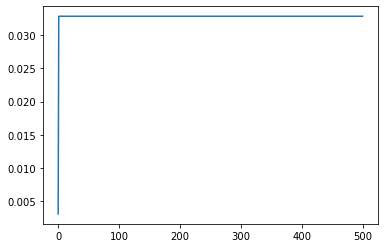

In [16]:
sns.lineplot(range(0, len(loss_history)), loss_history)

### Returns

<AxesSubplot:>

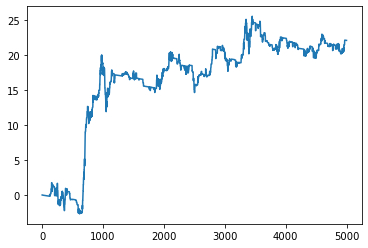

In [17]:
Ft = positions(rets, theta)

# TODO: These are zscores, convert back to normal returns
realised_returns = returns(Ft, rets, delta)
pd.Series(realised_returns).cumsum().plot()

### Positions

<AxesSubplot:>

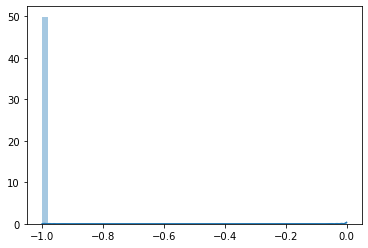

In [18]:
sns.distplot(Ft)

In [19]:
# Do i want to allow weights more than 1/-1?
# Is it only taking short positions as the bias weight is so large & negative?
theta

array([-4.23986063e+04, -6.22462878e+01, -5.41560348e+01, -6.29495747e+01,
       -5.71108131e+01, -3.12238212e+01, -5.68414652e+01, -1.33383205e+01,
        4.76089622e+03,  2.10589581e+04])